In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
%run -i helper_functions.py

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [4]:
df = pd.read_csv('output/engineered_sample_loan_data.csv')

In [5]:
df.shape

(178687, 38)

In [6]:
df.head()

,acc_now_delinq,annual_inc,individual_application,avg_cur_bal,bc_util,delinq_2yrs,dti,emp_length,inq_last_6mths,loan_amnt,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,fully_paid
0,0.0,120000.0,1,15203.0,44.0,0.0,33.73,10,0.0,20000.0,...,False,False,False,False,False,False,False,False,False,1
1,0.0,99000.0,1,5859.0,56.7,0.0,22.24,6,0.0,35000.0,...,False,False,False,False,False,False,False,False,False,0
2,0.0,100000.0,1,14660.0,14.8,0.0,13.40,8,2.0,17000.0,...,False,False,False,False,False,False,False,False,False,1
3,0.0,75000.0,1,18305.0,43.2,0.0,22.08,10,0.0,15000.0,...,False,False,False,False,False,False,False,False,False,1
4,0.0,118989.0,0,21741.0,93.9,0.0,20.13,10,0.0,38000.0,...,False,False,False,False,False,False,False,False,False,0


In [7]:
# List all non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns
non_numeric_columns


Index([], dtype='object')

In [8]:
# Drop all non-numeric columns
df = df.drop(columns=non_numeric_columns)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178687 entries, 0 to 178686
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   acc_now_delinq              178687 non-null  float64
 1   annual_inc                  178687 non-null  float64
 2   individual_application      178687 non-null  int64  
 3   avg_cur_bal                 178687 non-null  float64
 4   bc_util                     178687 non-null  float64
 5   delinq_2yrs                 178687 non-null  float64
 6   dti                         178687 non-null  float64
 7   emp_length                  178687 non-null  int64  
 8   inq_last_6mths              178687 non-null  float64
 9   loan_amnt                   178687 non-null  float64
 10  pub_rec                     178687 non-null  float64
 11  pub_rec_bankruptcies        178687 non-null  float64
 12  revol_bal                   178687 non-null  float64
 13  sub_grade     

In [10]:
# List all boolean columns
bool_columns = df.select_dtypes(include=['bool']).columns
bool_columns

Index(['home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [11]:
# Convert boolean columns to integers
df[bool_columns] = df[bool_columns].astype(int)

### Train/Test Split


In [12]:
# Set the feature variables
X = df.drop(columns='fully_paid')

# Set the target variable
y = df['fully_paid']

In [13]:
# Split the data into 4/5 training and 1/5 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


### Models Setup

In [14]:
columns_to_scale = ['acc_now_delinq', 'annual_inc', 'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'dti',
       'emp_length', 'sub_grade', 'inq_last_6mths', 'loan_amnt', 'pub_rec', 'pub_rec_bankruptcies', 
       'revol_bal', 'term', 'verification_status', 'fico_avg']

preprocessor = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    remainder="passthrough", 
    verbose_feature_names_out=False
)

#### Baseline Model

We will use a dummy classifier with the `most_frequent` strategy as the worst-case scenario given the significant class imbalance.


In [15]:
# Create a pipeline with a Logistic Regression model
pipe_dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy="most_frequent", random_state=42))
])
pipe_dummy

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acc_now_delinq',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_util', 'delinq_2yrs',
                                                   'dti', 'emp_length',
                                                   'sub_grade',
                                                   'inq_last_6mths',
                                                   'loan_amnt', 'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'revol_bal', 'term',
                                                   'verification_status',
                                                   'fico_avg'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

#### Logistic Regression Model

In [16]:
# Create a pipeline with a Logistic Regression model
pipe_logistic_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='saga', random_state=42, n_jobs=-1))
])
pipe_logistic_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acc_now_delinq',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_util', 'delinq_2yrs',
                                                   'dti', 'emp_length',
                                                   'sub_grade',
                                                   'inq_last_6mths',
                                                   'loan_amnt', 'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'revol_bal', 'term',
                                                   'verification_status',
                                                   'fico_avg'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='saga'))])

#### K-Nearest Neighbors

In [17]:
# Create a pipeline with a KNN model
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

#### Decision Trees

In [18]:
# Create a pipeline with a Decision Tree model
pipe_dtree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])


#### Support Vector Machines (SVM)

In [19]:
# Create a pipeline with a Decision Tree model
pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True, random_state=42))
])


### Model Comparisons


In [20]:
models = [
    'Baseline - DummyClassifer', 
    'Logistic Regression', 
#    'KNN', 
    'Decision Tree', 
#    'SVM'
]

pipe_dict = {
    'Baseline - DummyClassifer': pipe_dummy, 
    'Logistic Regression': pipe_logistic_reg, 
#    'KNN': pipe_knn, 
    'Decision Tree': pipe_dtree, 
#    'SVM': pipe_svm
}

train_times = {}
train_acc_dict = {}
test_acc_dict = {}
probabilities_dict = {}
roc_dict = {}
roc_auc_score_dict = {}

for model in models:
    print(model)
    start_time = dt.datetime.now()
    pipe_dict[model].fit(X_train, y_train)
    train_times[model] = dt.datetime.now() - start_time

    predictions = pipe_dict[model].predict(X_test)

    if model != 'Baseline - DummyClassifer':
        print(classification_report(y_test, predictions, zero_division=0))
    else:
        print(classification_report(y_test, predictions))

    print_prediction_metrics(y_test, predictions, model)

    train_acc_dict[model] = pipe_dict[model].score(X_train, y_train)
    test_acc_dict[model] = pipe_dict[model].score(X_test, y_test)

    probabilities_dict[model] = pipe_dict[model].predict_proba(X_test)[:, 1]
    roc_dict[model] = roc_curve(y_test, probabilities_dict[model])
    roc_auc_score_dict[model] = roc_auc_score(y_test, probabilities_dict[model])


Baseline - DummyClassifer
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7281
           1       0.80      1.00      0.89     28457

    accuracy                           0.80     35738
   macro avg       0.40      0.50      0.44     35738
weighted avg       0.63      0.80      0.71     35738

Model: Baseline - DummyClassifer
Accuracy: 0.7963
Precision: 0.7963
Recall: 1.0000
F1 Score: 0.8866
ROC AUC Score: 0.5000
Logistic Regression


/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.49      0.07      0.12      7281
           1       0.80      0.98      0.88     28457

    accuracy                           0.80     35738
   macro avg       0.65      0.52      0.50     35738
weighted avg       0.74      0.80      0.73     35738

Model: Logistic Regression
Accuracy: 0.7955
Precision: 0.8045
Recall: 0.9818
F1 Score: 0.8843
ROC AUC Score: 0.5246
Decision Tree
              precision    recall  f1-score   support

           0       0.27      0.29      0.28      7281
           1       0.82      0.80      0.81     28457

    accuracy                           0.69     35738
   macro avg       0.54      0.55      0.54     35738
weighted avg       0.70      0.69      0.70     35738

Model: Decision Tree
Accuracy: 0.6942
Precision: 0.8151
Recall: 0.7966
F1 Score: 0.8058
ROC AUC Score: 0.5452


In [21]:
summary_df = pd.DataFrame({
    'Model': models,
    'Train Time (Seconds)': np.array(train_times.values()),
    'Train Accuracy': list(train_acc_dict.values()),
    'Test Accuracy': list(test_acc_dict.values()),
    'ROC-AUC Score': list(roc_auc_score_dict.values())
})
summary_df

,Model,Train Time (Seconds),Train Accuracy,Test Accuracy,ROC-AUC Score
0,Baseline - DummyClassifer,0:00:00.023166,0.796256,0.796267,0.500000
1,Logistic Regression,0:00:03.614306,0.796788,0.795484,0.701835
2,Decision Tree,0:00:01.378297,1.000000,0.694163,0.545192


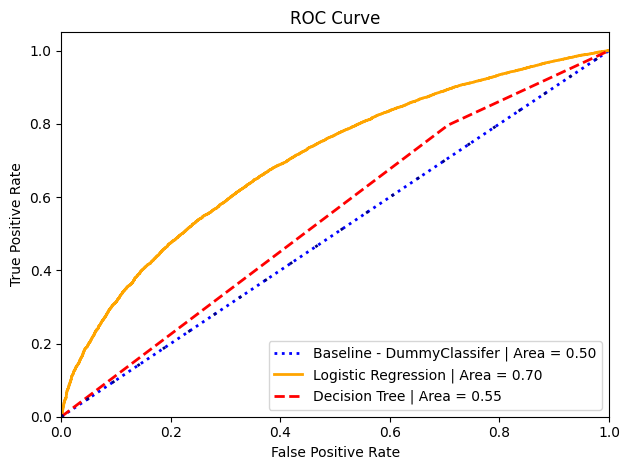

In [22]:
color_dict = {
    'Baseline - DummyClassifer': 'blue', 
    'Logistic Regression': 'orange', 
#    'KNN': 'green', 
    'Decision Tree': 'red', 
#    'SVM': 'purple'
}
linestyle_dict = {
    'Baseline - DummyClassifer': 'dotted',
    'Logistic Regression': 'solid', 
#    'KNN': 'dotted', 
    'Decision Tree': 'dashed', 
#    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in models:
    fpr, tpr, thresholds = roc_dict[model]
    roc_auc = roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Model Tuning

We will use GridSearch to find optimal hyperparameters for our models.  Since we are dealing with an imbalance target class, accuracy is not the best metric to use for scoring.  Since false positives are more harmful than false negatives, we will use precision as our scoring metric.  A high precision means we will minimize incorrect classification of bad loans as good loans.

In [23]:
tuned_train_acc_dict = {}
tuned_test_acc_dict = {}
tuned_probabilities_dict = {}
tuned_roc_dict = {}
tuned_roc_auc_score_dict = {}

#### Logistic Regression

From prior runs, our best parameters and score were as follows:

Best parameters: `{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}`

Score for best Logistic Regression estimator:  0.80

In [24]:
# search over different penalty options
lr_params = {
    'model__C': [0.1, 1, 10],  # smaller values specify stronger regularization
    'model__penalty': ['l1', 'l2'] # l1 is Lasso, l2 is Ridge
}

lr_search = GridSearchCV(pipe_logistic_reg, lr_params, scoring='precision', error_score='raise')

lr_search.fit(X_train, y_train)

/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acc_now_delinq',
                                                                          'annual_inc',
                                                                          'avg_cur_bal',
                                                                          'bc_util',
                                                                          'delinq_2yrs',
                                                                          'dti',
                                                                          'emp_length',
                                                                          'sub_grade',
                                                                          'inq_last_6mths',
                                                                          'loan_amnt',
                                                                          'pub_rec',
                                                                          'pub_rec_bankruptcies',
                                                                          'revol_bal',
                                                                          'term',
                                                                          'verification_status',
                                                                          'fico_avg'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l1', 'l2']},
             scoring='precision')

In [25]:
best_lr_model = lr_search.best_estimator_

lr_score = best_lr_model.score(X_test, y_test)

print(f'Best parameters: {lr_search.best_params_}')
print(f'Score for best Logistic Regression estimator: {lr_score: .2f}')

Best parameters: {'model__C': 1, 'model__penalty': 'l1'}
Score for best Logistic Regression estimator:  0.80


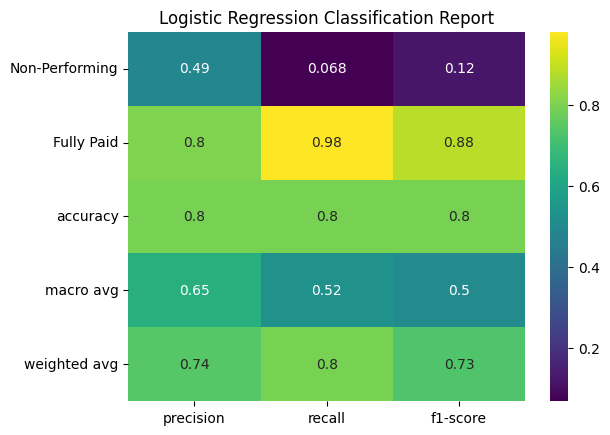

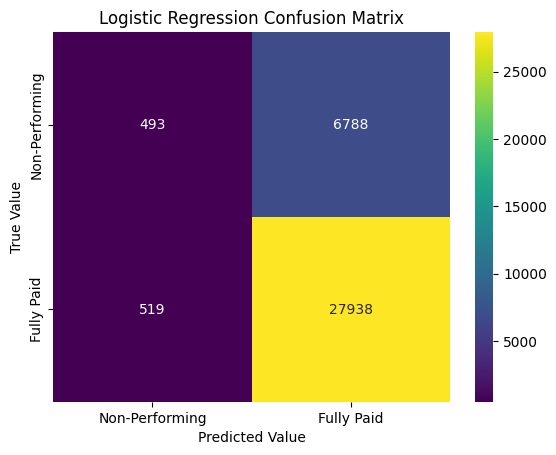

Model: Logistic Regression
Accuracy: 0.7955
Precision: 0.8045
Recall: 0.9818
F1 Score: 0.8844
ROC AUC Score: 0.5247


In [26]:
model_name = 'Logistic Regression'
label_names = ['Non-Performing', 'Fully Paid']

lr_predictions = best_lr_model.predict(X_test)

plot_classification_report(y_test, lr_predictions, label_names, model_name)
plot_confusion_heatmap(y_test, lr_predictions, label_names, model_name)
print_prediction_metrics(y_test, lr_predictions, model_name)

tuned_train_acc_dict[model_name] = best_lr_model.score(X_train, y_train)
tuned_test_acc_dict[model_name] = best_lr_model.score(X_test, y_test)

tuned_probabilities_dict[model_name] = best_lr_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model_name] = roc_curve(y_test, tuned_probabilities_dict[model_name])
tuned_roc_auc_score_dict[model_name] = roc_auc_score(y_test, tuned_probabilities_dict[model_name])

#### KNN

In [27]:
#knn_params = {
#    'model__n_neighbors': range(1, 20, 2),
#    'model__weights': ['uniform', 'distance'],
#    'model__metric': ['euclidean', 'manhattan', 'minkowski']
#}

#knn_search = GridSearchCV(pipe_knn, knn_params, scoring='f1')
#knn_search.fit(X_train, y_train)

In [28]:
#best_knn_model = knn_search.best_estimator_
#
#knn_score = best_knn_model.score(X_test, y_test)
#
#print(f'Best parameters: {knn_search.best_params_}')
#print(f'Score for best KNN estimator: {knn_score: .2f}')

In [29]:
#model = 'KNN'
#print(classification_report(y_test, best_knn_model.predict(X_test)))

#tuned_train_acc_dict[model] = best_knn_model.score(X_train, y_train)
#tuned_test_acc_dict[model] = best_knn_model.score(X_test, y_test)

#tuned_probabilities_dict[model] = best_knn_model.predict_proba(X_test)[:, 1]
#tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
#tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

In [30]:
#knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
#knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
#knn_cv_df

In [31]:
#plot knn scores
#knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
#knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
#sns.lineplot(data=knn_cv_df, x='model__n_neighbors', y='score', hue='model__weights', style='model__metric')
#plt.show()

#### Decision Tree

In [32]:
dt_params = {
    'model__max_depth': range(1, 10),
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': ['sqrt', 'log2'], # 'log_loss' criterion supports only 'auto
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

dt_search = GridSearchCV(pipe_dtree, dt_params, scoring='precision')
dt_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acc_now_delinq',
                                                                          'annual_inc',
                                                                          'avg_cur_bal',
                                                                          'bc_util',
                                                                          'delinq_2yrs',
                                                                          'dti',
                                                                          'emp_length',
                                                                          'sub_grade',
                                                                          'inq_last_6mths',
                                                                          'loan_amnt',
                                                                          'pub_rec',
                                                                          'pub_rec_bankruptcies',
                                                                          'revol_bal',
                                                                          'term',
                                                                          'verification_status',
                                                                          'fico_avg'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 10),
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='precision')

In [33]:
best_dt_model = dt_search.best_estimator_

dt_score = best_dt_model.score(X_test, y_test)

print(f'Best parameters: {dt_search.best_params_}')
print(f'Score for best Decision Tree estimator: {dt_score: .2f}')

Best parameters: {'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Score for best Decision Tree estimator:  0.79


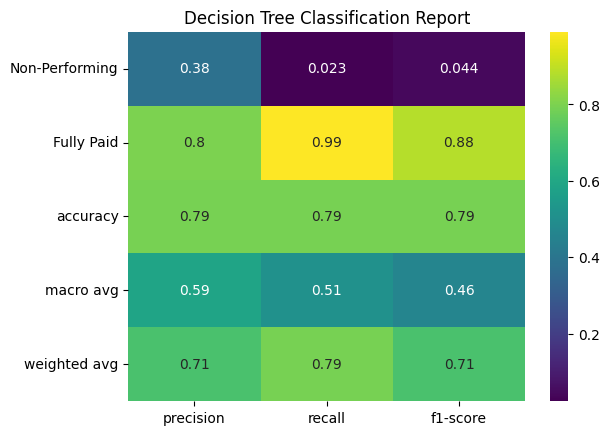

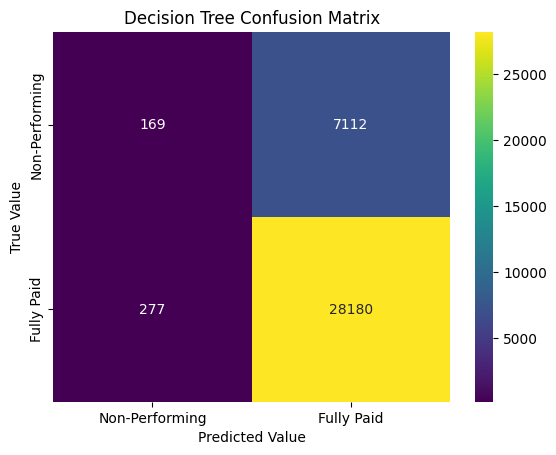

Model: Decision Tree
Accuracy: 0.7932
Precision: 0.7985
Recall: 0.9903
F1 Score: 0.8841
ROC AUC Score: 0.5067


In [34]:
model_name = 'Decision Tree'

dtree_predictions = best_dt_model.predict(X_test)

plot_classification_report(y_test, dtree_predictions, label_names, model_name)
plot_confusion_heatmap(y_test, dtree_predictions, label_names, model_name)
print_prediction_metrics(y_test, dtree_predictions, model_name)

tuned_train_acc_dict[model_name] = best_dt_model.score(X_train, y_train)
tuned_test_acc_dict[model_name] = best_dt_model.score(X_test, y_test)

tuned_probabilities_dict[model_name] = best_dt_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model_name] = roc_curve(y_test, tuned_probabilities_dict[model_name])
tuned_roc_auc_score_dict[model_name] = roc_auc_score(y_test, tuned_probabilities_dict[model_name])

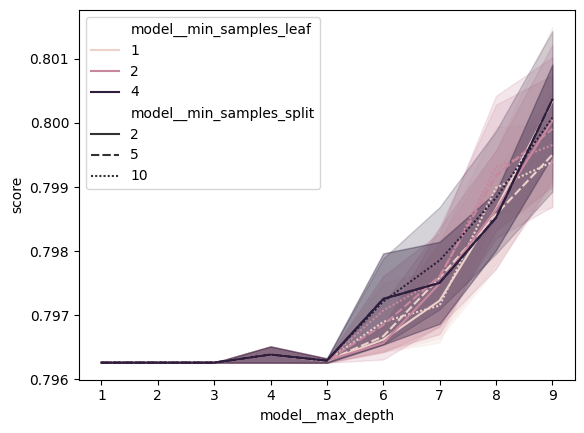

In [35]:
#plot decision tree scores
tree_cv_df = pd.DataFrame(dt_search.cv_results_['params'])
tree_cv_df['score'] = dt_search.cv_results_['mean_test_score']
sns.lineplot(data=tree_cv_df, x='model__max_depth', y='score', hue='model__min_samples_leaf', style='model__min_samples_split')
plt.show()

#### SVM

In [36]:
#svc_params = {
#    'model__C': [0.01, 0.1, 1, 10, 100],
#    'model__kernel': ['rbf'],
#    'model__gamma': [1, 0.1, 0.01, 0.001],
#}

#svc_search = GridSearchCV(pipe_svm, svc_params, scoring='recall')
#svc_search.fit(X_train, y_train)

In [37]:
#best_svc_model = svc_search.best_estimator_
#
#svc_score = best_svc_model.score(X_test, y_test)
#
#print(f'Best parameters: {svc_search.best_params_}')
#print(f'Score for best Decision Tree estimator: {svc_score: .2f}')

In [38]:
#model = 'SVM'
#print(classification_report(y_test, best_svc_model.predict(X_test)))
#
#tuned_train_acc_dict[model] = best_svc_model.score(X_train, y_train)
#tuned_test_acc_dict[model] = best_svc_model.score(X_test, y_test)

#tuned_probabilities_dict[model] = best_svc_model.predict_proba(X_test)[:, 1]
#tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
#tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

### Comparisons after hyperparameter tuning

In [39]:
#tuned_models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']
tuned_models = ['Logistic Regression', 'Decision Tree']

summary_df = pd.DataFrame({
    'Model': tuned_models,
    'Train Accuracy': list(tuned_train_acc_dict.values()),
    'Test Accuracy': list(tuned_test_acc_dict.values()),
    'ROC-AUC Score': list(tuned_roc_auc_score_dict.values())
})
summary_df

,Model,Train Accuracy,Test Accuracy,ROC-AUC Score
0,Logistic Regression,0.796788,0.795540,0.701838
1,Decision Tree,0.797865,0.793245,0.663721


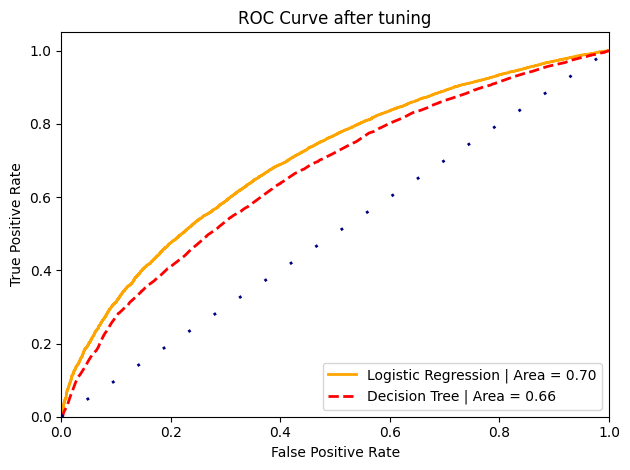

In [40]:
color_dict = {
    'Logistic Regression': 'orange', 
#    'KNN': 'green', 
    'Decision Tree': 'red', 
#    'SVM': 'purple'
}
linestyle_dict = {
    'Logistic Regression': 'solid', 
#    'KNN': 'dotted', 
    'Decision Tree': 'dashed', 
#    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in tuned_models:
    fpr, tpr, thresholds = tuned_roc_dict[model]
    roc_auc = tuned_roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after tuning')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance

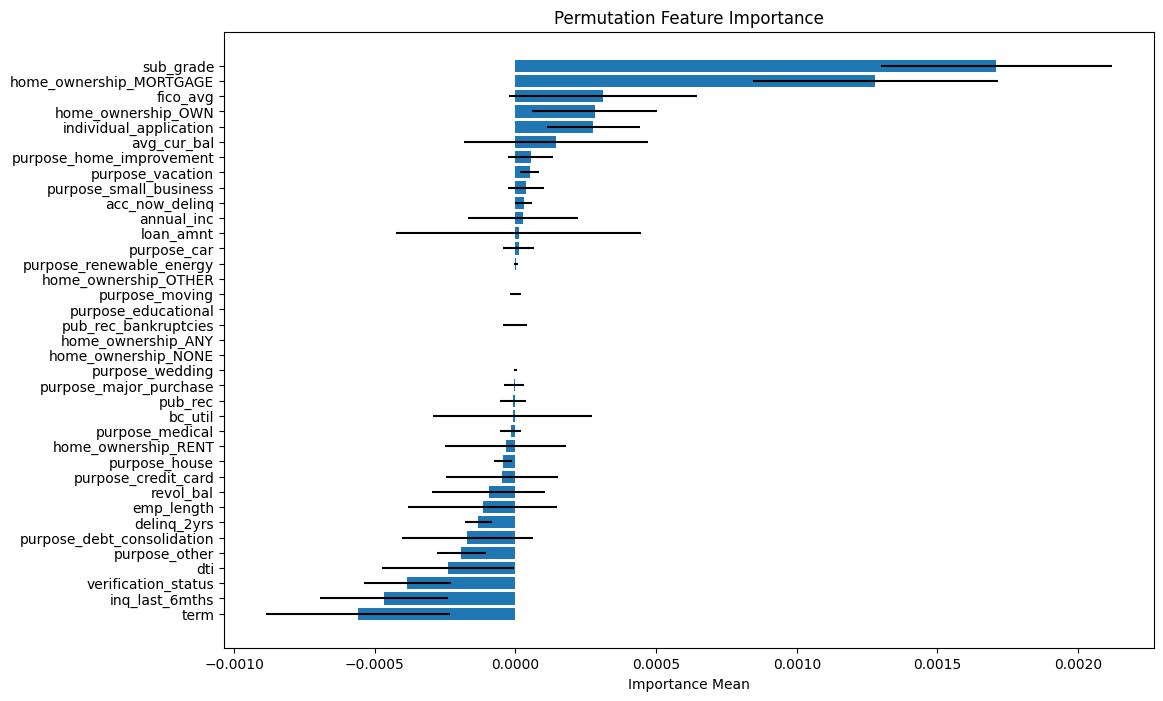

In [41]:
# Calculate permutation importance for Logistic Regression model
lr_perm_importance = permutation_importance(best_lr_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the feature names
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': lr_perm_importance.importances_mean,
    'Importance Std': lr_perm_importance.importances_std
})

# Sort the DataFrame by importance mean
importances_df = importances_df.sort_values(by='Importance Mean', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance Mean'], xerr=importances_df['Importance Std'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.title('Permutation Feature Importance')
plt.xlabel('Importance Mean')
plt.savefig('output/LogisticRegression_Permutation_Feature_Importance.png')
plt.show()

In [42]:
coefs = best_lr_model.named_steps.model.coef_
coefs[0]

array([ 0.00976171,  0.07480904,  0.15841558,  0.05879837,  0.00383606,
       -0.07008711,  0.07530139, -0.45050145, -0.04516269, -0.15388279,
        0.00171261,  0.00314767,  0.04541886, -0.18565896, -0.03173487,
        0.17788521,  0.26539483, -0.00096694,  0.41972265,  0.        ,
        0.        ,  0.24522815,  0.16618884,  0.22387095,  0.1474316 ,
        0.1176646 ,  0.        ,  0.07313907,  0.1386779 ,  0.0272624 ,
       -0.06524193,  0.05071086,  0.10205841,  0.00796562, -0.16444709,
        0.09136117,  0.03621127])

In [43]:
# Create DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs[0],
    'Abs_Coefs': np.abs(coefs[0])
})
coefs_df.sort_values(['Coefficient'], ascending = False).set_index('Feature')

,Coefficient,Abs_Coefs
Feature,,
home_ownership_MORTGAGE,0.419723,0.419723
fico_avg,0.265395,0.265395
home_ownership_OWN,0.245228,0.245228
purpose_car,0.223871,0.223871
verification_status,0.177885,0.177885
home_ownership_RENT,0.166189,0.166189
individual_application,0.158416,0.158416
purpose_credit_card,0.147432,0.147432
purpose_house,0.138678,0.138678


### Gradient Boosting

In [44]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 300, max_depth = 5, validation_fraction = 0.2, n_iter_no_change = 50)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=300, n_iter_no_change=50,
                           validation_fraction=0.2)

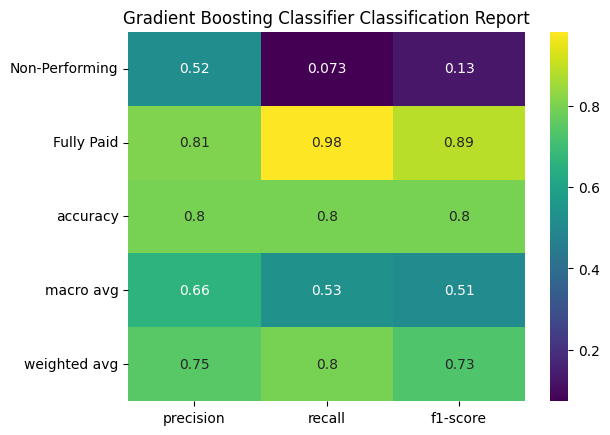

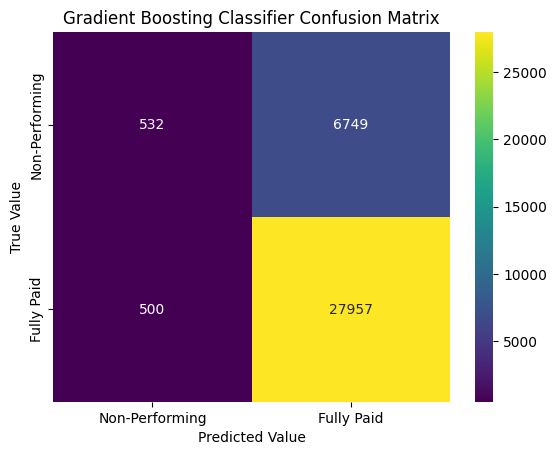

Model: Gradient Boosting Classifier
Accuracy: 0.7972
Precision: 0.8055
Recall: 0.9824
F1 Score: 0.8852
ROC AUC Score: 0.5277


(0.7971626839778387,
 0.8055379473289921,
 0.9824296306708367,
 0.8852334436299732,
 0.5277482585437688)

In [45]:
model_name = 'Gradient Boosting Classifier'
gbc_predictions = gbc.predict(X_test)

plot_classification_report(y_test, gbc_predictions, label_names, model_name)
plot_confusion_heatmap(y_test, gbc_predictions, label_names, model_name)
print_prediction_metrics(y_test, gbc_predictions, model_name)

### Deep Neural Network

In [46]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
#from keras.metrics import binary_accuracy, f1_score


In [47]:
preprocessor = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    remainder="passthrough", 
    verbose_feature_names_out=False
)

X_t = preprocessor.fit_transform(X)

In [48]:
# Split the data into 4/5 training and 1/5 testing sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20, random_state=42, stratify=y)

In [49]:
X_train.shape, X_test.shape

((142949, 37), (35738, 37))

In [50]:
len(y_train), len(y_test)

(142949, 35738)

In [51]:
X_train[0]

array([-0.05900313,  0.66679567,  0.27883329, -0.67309146, -0.3578368 ,
        1.07350973, -0.40620528,  2.94408553, -0.67607772,  2.36223596,
       -0.37032761, -0.36180157,  0.86179562, -0.58138485,  1.33327846,
        1.16611193,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [52]:
model = Sequential()
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='linear'))
model.add(Dense(1, activation = 'sigmoid'))

opt = optimizers.RMSprop(learning_rate=0.00001) # default is 0.001
model.compile(optimizer = opt,
             loss = 'binary_crossentropy',
             metrics = ['precision'])


In [58]:
# Adjust the weights of the classes to account for the imbalance
class_weight = {0: 4,
                1: 1.}

#model.fit(x = X_train,
#         y = y_train,
#         epochs = 4,
#         batch_size = 512,
#         validation_data = (X_test, y_test), class_weight=class_weight,
#         callbacks=[EarlyStopping(monitor='val_f1', mode='max', patience=30, restore_best_weights=True)])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 512,
                verbose = 2)

Epoch 1/50


280/280 - 15s - 54ms/step - loss: 0.4575 - precision: 0.8028
Epoch 2/50
280/280 - 15s - 53ms/step - loss: 0.4571 - precision: 0.8031
Epoch 3/50
280/280 - 15s - 54ms/step - loss: 0.4568 - precision: 0.8038
Epoch 4/50
280/280 - 15s - 54ms/step - loss: 0.4565 - precision: 0.8038
Epoch 5/50
280/280 - 15s - 53ms/step - loss: 0.4562 - precision: 0.8048
Epoch 6/50
280/280 - 15s - 53ms/step - loss: 0.4558 - precision: 0.8043
Epoch 7/50
280/280 - 15s - 53ms/step - loss: 0.4555 - precision: 0.8048
Epoch 8/50
280/280 - 15s - 53ms/step - loss: 0.4552 - precision: 0.8052
Epoch 9/50
280/280 - 15s - 54ms/step - loss: 0.4549 - precision: 0.8055
Epoch 10/50
280/280 - 15s - 54ms/step - loss: 0.4545 - precision: 0.8057
Epoch 11/50
280/280 - 15s - 55ms/step - loss: 0.4542 - precision: 0.8059
Epoch 12/50
280/280 - 15s - 54ms/step - loss: 0.4538 - precision: 0.8063
Epoch 13/50
280/280 - 15s - 54ms/step - loss: 0.4534 - precision: 0.8063
Epoch 14/50
280/280 - 15s - 54ms/step - loss: 0.4531 - precision: 0.806

In [59]:
history.history

{'loss': [0.45749348402023315,
  0.4570993483066559,
  0.45680713653564453,
  0.45650923252105713,
  0.4561578333377838,
  0.4558172821998596,
  0.45548415184020996,
  0.455206960439682,
  0.45486128330230713,
  0.4545106589794159,
  0.45422646403312683,
  0.4538434147834778,
  0.4534154534339905,
  0.4530865252017975,
  0.4527418315410614,
  0.4523141384124756,
  0.45195645093917847,
  0.45148733258247375,
  0.45104432106018066,
  0.4506871700286865,
  0.45015251636505127,
  0.44948965311050415,
  0.44901204109191895,
  0.448546439409256,
  0.44791024923324585,
  0.44735509157180786,
  0.44676473736763,
  0.44600534439086914,
  0.44544973969459534,
  0.44462430477142334,
  0.4437934458255768,
  0.443022221326828,
  0.44215312600135803,
  0.4415264129638672,
  0.4405357241630554,
  0.4393047094345093,
  0.43891119956970215,
  0.4375406801700592,
  0.43656125664711,
  0.4358416497707367,
  0.4349634349346161,
  0.43368008732795715,
  0.4327155649662018,
  0.4320603013038635,
  0.4305944

In [60]:
model_name = 'Deep Learning'
dl_predictions = model.predict(X_test)


   1/1117 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step

1117/1117 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


In [61]:
# Turn the probabilities into binary predictions
dl_binary_predictions = (dl_predictions > 0.5).astype(int)

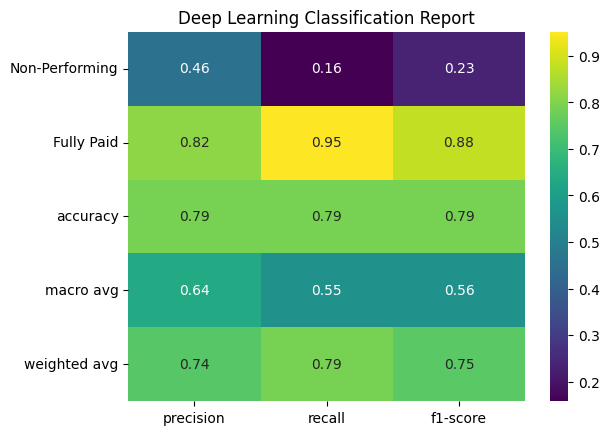

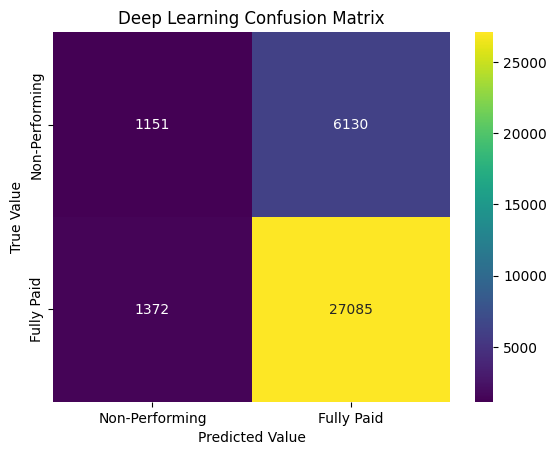

Model: Deep Learning
Accuracy: 0.7901
Precision: 0.8154
Recall: 0.9518
F1 Score: 0.8784
ROC AUC Score: 0.5549


(0.790083384632604,
 0.8154448291434593,
 0.9517869065607759,
 0.878356466467765,
 0.5549347937555974)

In [62]:
plot_classification_report(y_test, dl_binary_predictions, label_names, model_name)
plot_confusion_heatmap(y_test, dl_binary_predictions, label_names, model_name)
print_prediction_metrics(y_test, dl_binary_predictions, model_name)